In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nasa-battery-dataset/cleaned_dataset/metadata.csv
/kaggle/input/nasa-battery-dataset/cleaned_dataset/extra_infos/README_49_50_51_52.txt
/kaggle/input/nasa-battery-dataset/cleaned_dataset/extra_infos/README_45_46_47_48.txt
/kaggle/input/nasa-battery-dataset/cleaned_dataset/extra_infos/README_05_06_07_18.txt
/kaggle/input/nasa-battery-dataset/cleaned_dataset/extra_infos/README_29_30_31_32.txt
/kaggle/input/nasa-battery-dataset/cleaned_dataset/extra_infos/README_25_26_27_28.txt
/kaggle/input/nasa-battery-dataset/cleaned_dataset/extra_infos/README_33_34_36.txt
/kaggle/input/nasa-battery-dataset/cleaned_dataset/extra_infos/README_53_54_55_56.txt
/kaggle/input/nasa-battery-dataset/cleaned_dataset/extra_infos/README_41_42_43_44.txt
/kaggle/input/nasa-battery-dataset/cleaned_dataset/extra_infos/README_38_39_40.txt
/kaggle/input/nasa-battery-dataset/cleaned_dataset/data/02421.csv
/kaggle/input/nasa-battery-dataset/cleaned_dataset/data/04530.csv
/kaggle/input/nasa-battery-dataset/c

In [18]:
import os
import pandas as pd
path="/kaggle/input/nasa-battery-dataset"
metadata = pd.read_csv(
    os.path.join(path, "cleaned_dataset", "metadata.csv")
)
print(metadata.head())

        type                                         start_time  \
0  discharge  [2010.       7.      21.      15.       0.    ...   
1  impedance  [2010.       7.      21.      16.      53.    ...   
2     charge  [2010.       7.      21.      17.      25.    ...   
3  impedance                    [2010    7   21   20   31    5]   
4  discharge  [2.0100e+03 7.0000e+00 2.1000e+01 2.1000e+01 2...   

   ambient_temperature battery_id  test_id  uid   filename  \
0                    4      B0047        0    1  00001.csv   
1                   24      B0047        1    2  00002.csv   
2                    4      B0047        2    3  00003.csv   
3                   24      B0047        3    4  00004.csv   
4                    4      B0047        4    5  00005.csv   

             Capacity                   Re                  Rct  
0  1.6743047446975208                  NaN                  NaN  
1                 NaN  0.05605783343888099  0.20097016584458333  
2                 NaN     

In [19]:
V_CUTOFF = 2.7
CAPACITY_MIN_AH = 1
BINS = 20
M = 200  # physics resolution 
NOMINAL_AH = 2.0

In [20]:
metadata["battery_id"] = metadata["battery_id"].astype(str)
excluded_batteries = ["B0049", "B0050", "B0051", "B0052"]
discharge_metadata = metadata[
    (metadata["type"] == "discharge") &
    (~metadata["battery_id"].isin(excluded_batteries))
].copy()
discharge_metadata["cycle_number"] = discharge_metadata.groupby("battery_id").cumcount() + 1

In [24]:
from tqdm import tqdm

main_rows = []
phys_rows = []

for _, row in tqdm(discharge_metadata.iterrows(), total=len(discharge_metadata)):
    file_path = os.path.join(path, "cleaned_dataset", "data", row["filename"])
    df = pd.read_csv(file_path).copy()

   #sorting
    df = df.sort_values("Time").drop_duplicates(subset=["Time"], keep="first")
    if len(df) < 5:
        continue

    # truncate at cutoff voltage
    cutoff_idx = df[df["Voltage_measured"] < V_CUTOFF].index.min()
    if not pd.isna(cutoff_idx):
        df = df.loc[:cutoff_idx].copy()

    if len(df) < 5:
        continue

    # coulomb count on raw points for labels
    df["dt_hr_raw"] = df["Time"].diff().fillna(0) / 3600.0
    df["dQ"] = df["Current_measured"] * df["dt_hr_raw"]
    capacity = abs(df["dQ"].sum())

    if capacity <= CAPACITY_MIN_AH or capacity>=NOMINAL_AH:
        continue

    # SoC based on this cycle's capacity 
    df["CumQ"] = df["dQ"].cumsum()
    df["SoC"] = 100.0 * (1.0 + df["CumQ"] / capacity)

    soh_value = 100.0 * capacity / NOMINAL_AH

    # resample each cycle to M time points 
    t = df["Time"].to_numpy()
    t0, t1 = float(t[0]), float(t[-1])
    if t1 <= t0:
        continue

    t_grid = np.linspace(t0, t1, M)
    dt_hr = np.diff(t_grid, prepend=t_grid[0]) / 3600.0

    def interp(col):
        return np.interp(t_grid, t, df[col].to_numpy())

    Vg   = interp("Voltage_measured")
    Ig   = interp("Current_measured")
    Tg   = interp("Temperature_measured")
    SOCg = interp("SoC")

    # PHYSICS DATASET (resampled, not binned) 
    for j in range(M):
        phys_rows.append({
            "battery_id": row["battery_id"],
            "cycle_number": row["cycle_number"],
            "t_idx": j,
            "Time_s": t_grid[j] - t0,
            "dt_hr": dt_hr[j],
            "Voltage_measured": Vg[j],
            "Current_measured": Ig[j],
            "Temperature_measured": Tg[j],
            "SoC": SOCg[j],
            "Capacity_Ah": capacity,
            "SoH": soh_value,
            "t_end_s": (t1 - t0),
        })

    # MAIN DATASET (20 bins from the resampled series) 
    rs = pd.DataFrame({
        "Time_s": t_grid - t0,
        "dt_hr": dt_hr,
        "Voltage_measured": Vg,
        "Current_measured": Ig,
        "Temperature_measured": Tg,
        "SoC": SOCg,
    })

    chunks = np.array_split(rs, BINS)
    if len(chunks) != BINS or any(c.empty for c in chunks):
        continue

    for b_idx, c in enumerate(chunks):
        main_rows.append({
            "battery_id": row["battery_id"],
            "cycle_number": row["cycle_number"],
            "bin_idx": b_idx,

            "Time_s": c["Time_s"].mean(),
            "dt_hr": c["dt_hr"].sum(),  # total time represented by this bin

            "Voltage_measured": c["Voltage_measured"].mean(),
            "Current_measured": c["Current_measured"].mean(),
            "Temperature_measured": c["Temperature_measured"].mean(),
            "SoC": c["SoC"].mean(),

            "Capacity_Ah": capacity,
            "SoH": soh_value,
            "t_end_s": (t1 - t0),
        })

main_df = pd.DataFrame(main_rows)
phys_df = pd.DataFrame(phys_rows)

main_df.to_csv("battery_main_binned20.csv", index=False)
phys_df.to_csv("battery_phys_resampled200.csv", index=False)

print("Saved:", main_df.shape, phys_df.shape)


  0%|          | 0/2694 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/usr/local/lib/python3.1

Saved: (45660, 12) (456600, 12)


In [63]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

main_df = pd.read_csv("/kaggle/working/battery_main_binned20.csv")
phys_df = pd.read_csv("/kaggle/working/battery_phys_resampled200.csv")
phys_df.head()

,battery_id,cycle_number,t_idx,Time_s,dt_hr,Voltage_measured,Current_measured,Temperature_measured,SoC,Capacity_Ah,SoH,t_end_s
0,B0047,1,0,0.000000,0.000000,4.246711,0.000252,6.212696,100.000000,1.676224,83.811222,6071.906
1,B0047,1,1,30.512090,0.008476,4.028385,-0.995996,6.278860,99.650780,1.676224,83.811222,6071.906
2,B0047,1,2,61.024181,0.008476,3.994477,-0.995535,6.394532,99.147795,1.676224,83.811222,6071.906
3,B0047,1,3,91.536271,0.008476,3.970792,-0.997871,5.960556,98.643951,1.676224,83.811222,6071.906
4,B0047,1,4,122.048362,0.008476,3.951566,-0.993963,5.709974,98.141356,1.676224,83.811222,6071.906


In [30]:
FEATURES = [
    "Voltage_measured",
    "Current_measured",
    "Temperature_measured",
    "SoC"
]


In [31]:
X, y = [], []

for (bid, cycle), g in main_df.groupby(["battery_id", "cycle_number"]):
    g = g.sort_values("bin_idx")
    if len(g) != 20:
        continue

    X.append(g[FEATURES].values)        # (20, 4)
    y.append(g["SoH"].iloc[0])          # cycle-level SoH

X = np.array(X)
y = np.array(y)

print("X:", X.shape, "y:", y.shape)



X: (2283, 20, 4) y: (2283,)


In [32]:
scaler = StandardScaler()

X_flat = X.reshape(-1, 4)          # (-1, 4)
X_scaled = scaler.fit_transform(X_flat)
X = X_scaled.reshape(-1, 20, 4)


In [36]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [37]:
class BatteryDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


train_loader = DataLoader(
    BatteryDataset(X_train, y_train),
    batch_size=32,
    shuffle=True
)

val_loader = DataLoader(
    BatteryDataset(X_val, y_val),
    batch_size=32,
    shuffle=False
)


In [38]:
class SoHTransformer(nn.Module):
    def __init__(self, input_dim=4, d_model=64, nhead=4, num_layers=2):
        super().__init__()

        self.embedding = nn.Linear(input_dim, d_model)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            batch_first=True,
            norm_first=True   # PreNorm (more stable)
        )

        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        self.regressor = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.embedding(x)      # (B, 20, d_model)
        x = self.encoder(x)        # (B, 20, d_model)
        x = x.mean(dim=1)          # global pooling
        return self.regressor(x).squeeze()


In [39]:
def voltage_monotonic_loss(phys_df):
    losses = []

    for (bid, cycle), g in phys_df.groupby(["battery_id", "cycle_number"]):
        g = g.sort_values("t_idx")

        V = torch.tensor(
            g["Voltage_measured"].values,
            dtype=torch.float32
        )

        dV = V[1:] - V[:-1]     # V(k+1) - V(k)

        # Penalize only if voltage increases
        losses.append(torch.mean(torch.relu(dV)))

    return torch.mean(torch.stack(losses))


In [40]:
def soc_coulomb_loss(phys_df):
    losses = []

    for (bid, cycle), g in phys_df.groupby(["battery_id", "cycle_number"]):
        g = g.sort_values("t_idx")

        I  = torch.tensor(g["Current_measured"].values)
        dt = torch.tensor(g["dt_hr"].values)
        soc = torch.tensor(g["SoC"].values)

        # Coulomb-counted SoC change
        dQ = torch.cumsum(I * dt, dim=0)
        soc_hat = soc[0] + 100.0 * dQ / (g["Capacity_Ah"].iloc[0])

        losses.append(torch.mean((soc_hat - soc) ** 2))

    return torch.mean(torch.stack(losses))


In [44]:
def physics_loss(phys_df,
                 w_soc=1.0,
                 w_v=0.5):

    soc_loss = soc_coulomb_loss(phys_df)
    v_loss   = voltage_monotonic_loss(phys_df)

    return w_soc * soc_loss + w_v * v_loss


In [46]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = SoHTransformer().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

lambda_phys = 0.01   # physics weight
for epoch in range(20):
    model.train()
    train_loss = 0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)

        optimizer.zero_grad()

        preds = model(xb)
        data_loss = criterion(preds, yb)

        phys_l = physics_loss(phys_df)

        loss = data_loss + lambda_phys * phys_l
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            val_loss += criterion(model(xb), yb).item()

    val_loss /= len(val_loader)

    print(
        f"Epoch {epoch+1:02d} | "
        f"Train {train_loss:.3f} | "
        f"Val {val_loss:.3f}"
    )


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Epoch 01 | Train 571.730 | Val 62.710
Epoch 02 | Train 38.319 | Val 40.273
Epoch 03 | Train 26.737 | Val 29.211
Epoch 04 | Train 21.739 | Val 40.299
Epoch 05 | Train 18.246 | Val 30.545
Epoch 06 | Train 15.507 | Val 16.222
Epoch 07 | Train 15.210 | Val 41.394
Epoch 08 | Train 15.664 | Val 18.565
Epoch 09 | Train 13.822 | Val 19.871
Epoch 10 | Train 14.052 | Val 20.470
Epoch 11 | Train 13.751 | Val 16.887
Epoch 12 | Train 13.362 | Val 28.540
Epoch 13 | Train 12.378 | Val 13.943
Epoch 14 | Train 12.867 | Val 33.064
Epoch 15 | Train 13.044 | Val 22.631
Epoch 16 | Train 15.440 | Val 53.843
Epoch 17 | Train 15.349 | Val 17.933
Epoch 18 | Train 11.495 | Val 22.600
Epoch 19 | Train 10.868 | Val 14.052
Epoch 20 | Train 14.302 | Val 19.982


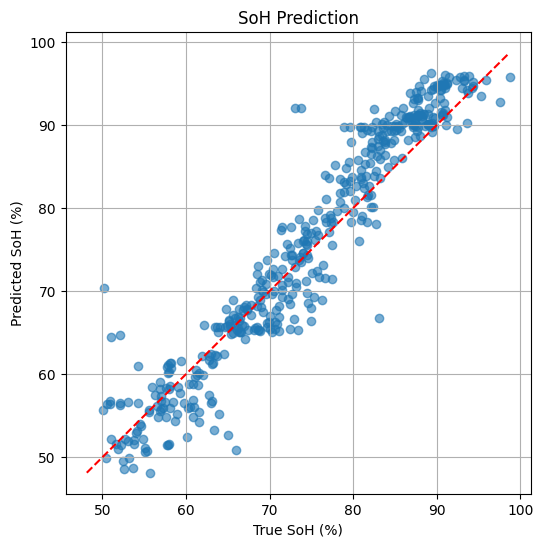

In [50]:
import matplotlib.pyplot as plt

model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for xb, yb in val_loader:   # ← FIX HERE
        xb = xb.to(device)
        preds = model(xb).cpu().numpy()

        y_pred.extend(preds)
        y_true.extend(yb.numpy())

plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred, alpha=0.6)

mn = min(min(y_true), min(y_pred))
mx = max(max(y_true), max(y_pred))
plt.plot([mn, mx], [mn, mx], 'r--')

plt.xlabel("True SoH (%)")
plt.ylabel("Predicted SoH (%)")
plt.title("SoH Prediction")
plt.grid(True)
plt.show()


In [70]:
class SoHTransformer(nn.Module):
    def __init__(self, input_dim=4, d_model=64, nhead=4, num_layers=2):
        super().__init__()

        self.embedding = nn.Linear(input_dim, d_model)

        self.layers = nn.ModuleList([
            nn.TransformerEncoderLayer(
                d_model=d_model,
                nhead=nhead,
                batch_first=True
            ) for _ in range(num_layers)
        ])

        self.regressor = nn.Linear(d_model, 1)

        self.attn_maps = []

    def forward(self, x, return_attn=False):
        self.attn_maps = []

        x = self.embedding(x)

        for layer in self.layers:
            # Capture attention
            attn_out, attn = layer.self_attn(
                x, x, x,
                need_weights=True,
                average_attn_weights=False
            )
            self.attn_maps.append(attn)

            # Run full encoder layer (correct!)
            x = layer(x)

        x = x.mean(dim=1)
        out = self.regressor(x)

        if return_attn:
            return out.squeeze(), self.attn_maps

        return out.squeeze()
model = SoHTransformer().to(device)

In [71]:
import inspect
print(inspect.signature(model.forward))


(x, return_attn=False)


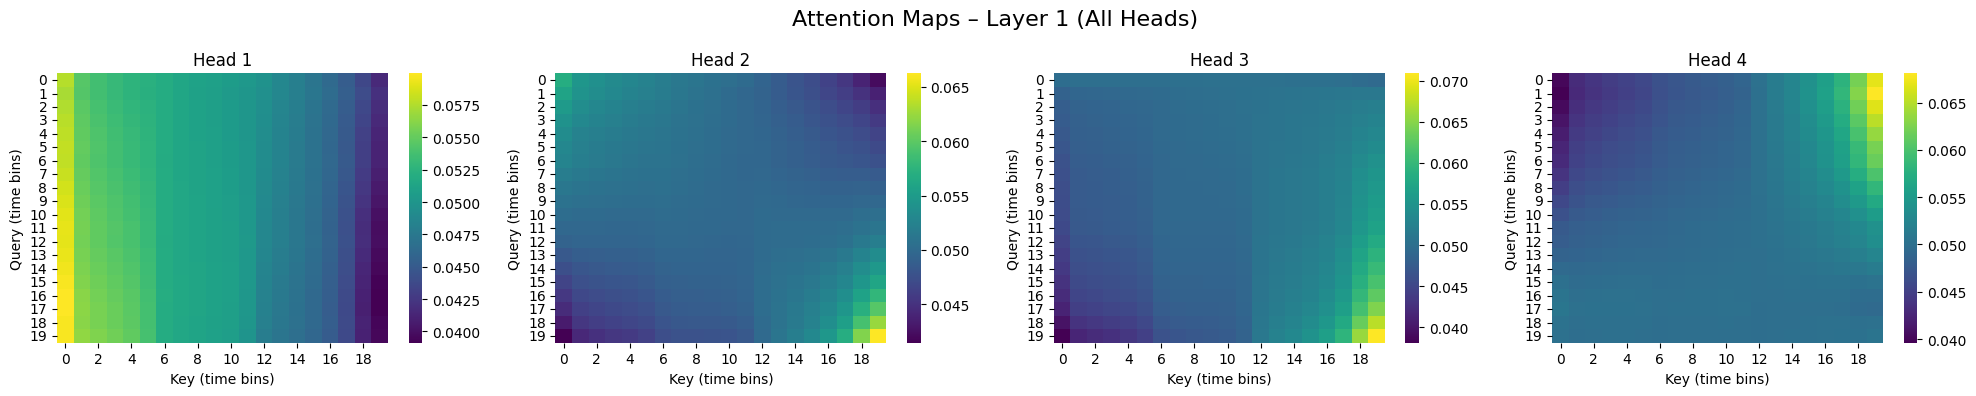

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns

model.eval()

xb, yb = next(iter(val_loader))
xb = xb.to(device)

with torch.no_grad():
    _, attns = model(xb, return_attn=True)

# Choose layer and sample
layer_idx = 0     # Layer 1
sample_idx = 0    # First sample in batch

fig, axes = plt.subplots(1, 4, figsize=(20, 4))

for h in range(4):
    A = attns[layer_idx][sample_idx, h].detach().cpu().numpy()
    sns.heatmap(
        A,
        ax=axes[h],
        cmap="viridis",
        cbar=True
    )
    axes[h].set_title(f"Head {h+1}")
    axes[h].set_xlabel("Key (time bins)")
    axes[h].set_ylabel("Query (time bins)")

plt.suptitle("Attention Maps – Layer 1 (All Heads)", fontsize=16)
plt.tight_layout()
plt.show()


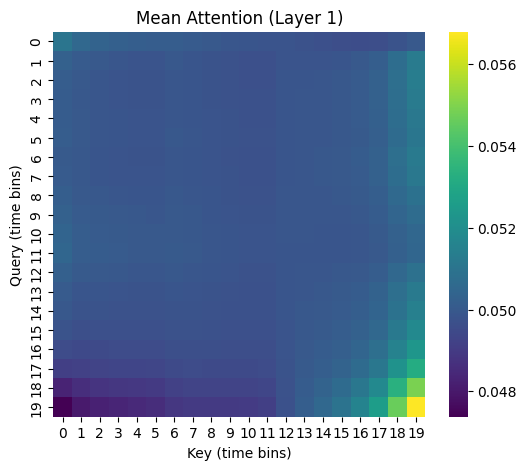

In [74]:
A_mean = attns[layer_idx][sample_idx].mean(axis=0).detach().cpu().numpy()

plt.figure(figsize=(6,5))
sns.heatmap(A_mean, cmap="viridis")
plt.title("Mean Attention (Layer 1)")
plt.xlabel("Key (time bins)")
plt.ylabel("Query (time bins)")
plt.show()
